# Neural Network

In [5]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping




In [6]:
"Read in clean-data"
df = pd.read_csv("clean_df.csv")

In [7]:
"Configure features and target"
# Define target column
target_col = "Price"

# Split features/target
x = df.drop(columns=[target_col])
y = df[target_col].astype(float)

In [8]:
"Configure features and target"
# Define target column
target_col = "Price"

# Split features/target
x = df.drop(columns=[target_col])
y = df[target_col].astype(float)

In [9]:
"Split data into training and test sets"
# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [10]:
"Preprocess data"
print(f"Original X_train shape: {X_train.shape}")
print(f"Data types:\n{X_train.dtypes}")


# One-hot encoding for categorical variables
X_train_processed = pd.get_dummies(X_train, drop_first=True)
X_test_processed = pd.get_dummies(X_test, drop_first=True)

# Update variables for cross-validation
X_train = X_train_processed
X_test = X_test_processed

Original X_train shape: (39990, 7)
Data types:
Manufacturer            object
Model                   object
Engine size            float64
Fuel type               object
Year of manufacture      int64
Mileage                  int64
Car Age                  int64
dtype: object


In [11]:
"Cross-validation setup"
k_folds = 5 # Number of folds
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Define parameter grid to test 
param_combinations = [
    {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'hidden_size': 64},
    {'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'hidden_size': 128},
    {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'hidden_size': 64},
]

In [12]:
"Cross-validation function"
def cv_params(X_train, y_train, param_list, k_folds=5):
    """Cross-validation for neural network hyperparameters"""
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    best_score, best_params = float('inf'), None
    
    for i, params in enumerate(param_list):
        print(f"\nTesting {i+1}/{len(param_list)}: {params}")
        scores = []
        
        # Split and scale data
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X_train.iloc[train_idx])
            X_val = scaler.transform(X_train.iloc[val_idx])
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            # Build model
            model = Sequential([
                Dense(params['hidden_size'], activation='relu', input_dim=X_tr.shape[1]),
                Dense(params['hidden_size']//2, activation='relu'),
                Dense(params['hidden_size']//4, activation='relu'),
                Dense(1)
            ])
            model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mse')
            
            # Train
            model.fit(X_tr, y_tr, epochs=params['epochs'], batch_size=params['batch_size'],
                     validation_data=(X_val, y_val), verbose=0,
                     callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
            
            # Evaluate
            score = mean_squared_error(y_val, model.predict(X_val, verbose=0))
            scores.append(score)
            print(f"  Fold {fold+1}: {score:.4f}")
        
        # Track best
        avg_score = np.mean(scores)
        print(f"  Average: {avg_score:.4f} ± {np.std(scores):.4f}")
        
        if avg_score < best_score:
            best_score, best_params = avg_score, params
    
    print(f"Best: {best_params} (MSE: {best_score:.4f})")
    return best_params, best_score, []

In [13]:
"Run cross-validation to find best parameters"
best_params, best_score, all_results = cv_params(
    X_train, y_train, 
    param_combinations, 
    k_folds=5
)

print("\nAll parameter combinations tested:")
for i, result in enumerate(all_results):
    print(f"\n{i+1}. {result['params']}")
    print(f"   Average MSE: {result['avg_score']:.4f} ± {result['std_score']:.4f}")
    print(f"   Fold scores: {[f'{score:.4f}' for score in result['fold_scores']]}")

# Print best parameters
print(f"   BEST PARAMETERS FOUND:")
print(f"   Parameters: {best_params}")
print(f"   Best CV Score (MSE): {best_score:.4f}")
print(f"   Best CV Score (RMSE): {np.sqrt(best_score):.4f}")


Testing 1/3: {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'hidden_size': 64}


c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 1: 43775.5730


c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 2: 54282.8195


c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 3: 44828.5188


c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 4: 51814.0049


c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 5: 42706.4917
  Average: 47481.4816 ± 4660.5033

Testing 2/3: {'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'hidden_size': 128}


c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 1: 103556.6909


c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 2: 166188.9858


c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 3: 42793.0948


c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 4: 28553.9231


c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 5: 87438.8240
  Average: 85706.3037 ± 48799.6684

Testing 3/3: {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'hidden_size': 64}


c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 1: 20152.6656


c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 2: 44412.5257


c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 3: 57941.9504


c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 4: 46608.3456


c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 5: 29874.8356
  Average: 39798.0646 ± 13276.1888
Best: {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'hidden_size': 64} (MSE: 39798.0646)

All parameter combinations tested:
   BEST PARAMETERS FOUND:
   Parameters: {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'hidden_size': 64}
   Best CV Score (MSE): 39798.0646
   Best CV Score (RMSE): 199.4945


In [14]:
"Training final model with best parameters"

# Scale the full training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create final model with best params
def create_final_model(params, input_dim):
    model = Sequential([
        Dense(params['hidden_size'], activation='relu', input_dim=input_dim),
        Dense(params['hidden_size']//2, activation='relu'),
        Dense(params['hidden_size']//4, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    return model

# Train final model
final_model = create_final_model(best_params, X_train_scaled.shape[1])

history = final_model.fit(
    X_train_scaled, y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_split=0.2,  # Use 20% of training data for monitoring
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)]
)

print("Final model training complete!")

Epoch 1/100


c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 301660896.0000 - mae: 9902.3770 - val_loss: 52768520.0000 - val_mae: 3775.5010
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 40025116.0000 - mae: 3249.9529 - val_loss: 29971496.0000 - val_mae: 2675.9714
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 27539218.0000 - mae: 2655.3196 - val_loss: 23035512.0000 - val_mae: 2311.0408
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 22205138.0000 - mae: 2256.0710 - val_loss: 19168542.0000 - val_mae: 1863.3207
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 18430918.0000 - mae: 1874.3699 - val_loss: 15395164.0000 - val_mae: 1686.0492
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 15185707.0000 - mae: 1569.0646 - val_loss: 12723777.0000 - val_mae: 1322.7354
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 12237122.0000 - mae: 1308.9359 - val_loss: 10017689.0000 - val_mae: 1194.7823
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━

In [15]:
"Newtwork summary and size"
final_model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,677 (49.52 KB)

 Trainable params: 4,225 (16.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,452 (33.02 KB)

   Final test results:
   Mean Squared Error (MSE): 41423.4602
   Root Mean Squared Error (RMSE): 203.5275
   Mean Absolute Error (MAE): 132.1809
   R² Score: 0.9998
   Comparison:
   Cross-Validation RMSE: 199.4945
   Final Test RMSE: 203.5275
   Difference: 4.0330


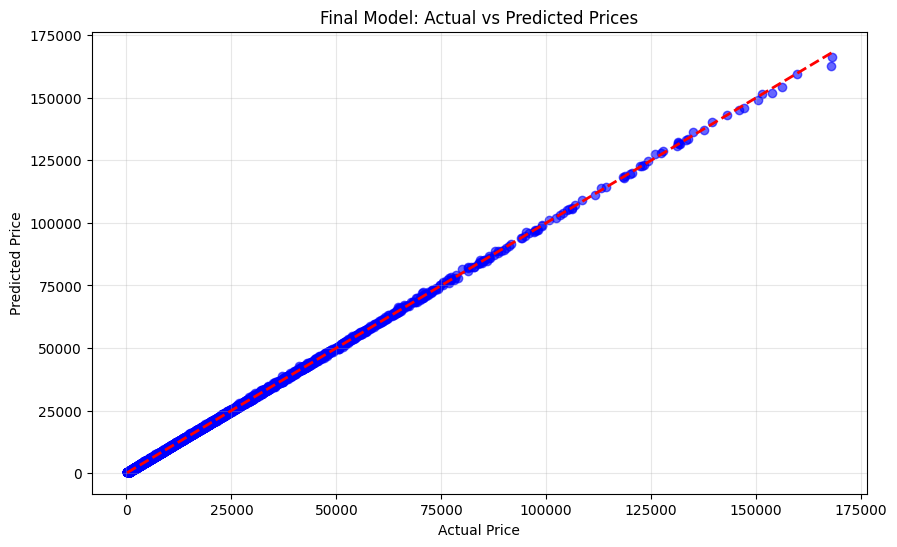

In [16]:
"Evaluate final model on test set"

# Make predictions on test set
test_predictions = final_model.predict(X_test_scaled, verbose=0)

# Calculate metrics
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

# Print results
print(f"   Final test results:")
print(f"   Mean Squared Error (MSE): {mse:.4f}")
print(f"   Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"   Mean Absolute Error (MAE): {mae:.4f}")
print(f"   R² Score: {r2:.4f}")

print(f"   Comparison:")
print(f"   Cross-Validation RMSE: {np.sqrt(best_score):.4f}")
print(f"   Final Test RMSE: {rmse:.4f}")
print(f"   Difference: {abs(rmse - np.sqrt(best_score)):.4f}")

# Plot (predictions vs actual)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Final Model: Actual vs Predicted Prices')
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
"Save model"

#Metadata
model_info = {
    'best_params': best_params,
    'best_score': best_score,
    'feature_names': list(X_train.columns),
    'model_type': 'neural_network'
}

joblib.dump({
    'model': final_model,
    'scaler': scaler,
    'feature_names': list(X_train.columns),
    'metadata': model_info
}, 'NN_model.joblib')

# Load
loaded = joblib.load('NN_model.joblib')
model = loaded['model']
scaler = loaded['scaler']

In [18]:
"Function to predict on new data"
def predict_price(new_data):    
    new_data_scaled = scaler.transform(new_data)
    prediction = model.predict(new_data_scaled)
    return prediction[0][0]

In [19]:
"Example"
new_car_data = pd.DataFrame({
    'Make': ['Toyota'],
    'Model': ['Camry'],
    'Year': [2023],
    'Mileage': [25000],
    'Engine_Size': [2.5],
})

In [33]:
"Test prediction on samples from test set"
sample_new_data = X_test.iloc[:10].copy()  # Test samples
actual_prices = y_test.iloc[:10].copy()    # Actual prices (for comparison)

for i in range(len(sample_new_data)):
    sample_scaled = scaler.transform([sample_new_data.iloc[i]])

    # Make prediction
    predicted_price = model.predict(sample_scaled, verbose=0)[0][0]
    actual_price = actual_prices.iloc[i]
    

    print(f"Sample {i+1}:")
    print(f"  Predicted Price: £{predicted_price:,.4f}")
    print(f"  Actual Price:    £{actual_price:,.4f}")
    print(f"  Error:           £{abs(predicted_price - actual_price):,.4f}\n")
    #print(f"Sample {i+1}:")
    #print(f"  Predicted Price: ${predicted_price:.2f}")
    #print(f"  Actual Price: ${actual_price:.2f}")
    #print(f"  Error: ${abs(predicted_price - actual_price):.2f}")
    #print()

c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Sample 1:
  Predicted Price: £28,908.2480
  Actual Price:    £28,636.0000
  Error:           £272.2480

Sample 2:
  Predicted Price: £59,868.3867
  Actual Price:    £59,783.0000
  Error:           £85.3867

Sample 3:
  Predicted Price: £14,754.5684
  Actual Price:    £14,865.0000
  Error:           £110.4316



c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Sample 4:
  Predicted Price: £2,342.6877
  Actual Price:    £2,219.0000
  Error:           £123.6877

Sample 5:
  Predicted Price: £1,097.0349
  Actual Price:    £1,001.0000
  Error:           £96.0349

Sample 6:
  Predicted Price: £1,387.9613
  Actual Price:    £1,415.0000
  Error:           £27.0387

Sample 7:
  Predicted Price: £105,547.2266
  Actual Price:    £106,073.0000
  Error:           £525.7734



c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Sample 8:
  Predicted Price: £1,990.8967
  Actual Price:    £2,023.0000
  Error:           £32.1033

Sample 9:
  Predicted Price: £15,455.7637
  Actual Price:    £15,492.0000
  Error:           £36.2363

Sample 10:
  Predicted Price: £3,392.9536
  Actual Price:    £3,465.0000
  Error:           £72.0464



  Processed 1/24 features...
  Processed 11/24 features...
  Processed 21/24 features...


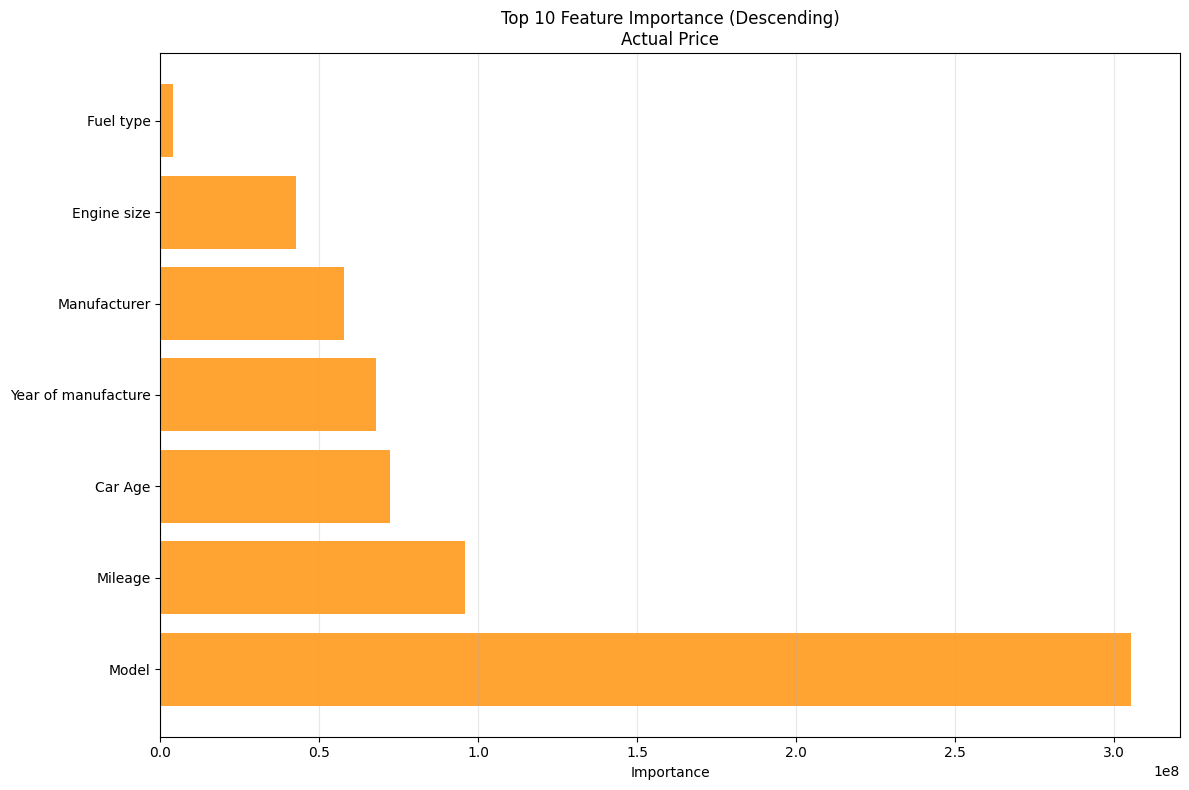

In [21]:
"Feature importance by permutation"
baseline_predictions = final_model.predict(X_test_scaled, verbose=0).flatten()
baseline_mse = mean_squared_error(y_test, baseline_predictions)

# Calculate importance for each feature
feature_importance_scores = []

for i, feature_name in enumerate(X_train.columns):
    X_test_permuted = X_test_scaled.copy()
    np.random.seed(42)
    X_test_permuted[:, i] = np.random.permutation(X_test_permuted[:, i])
    permuted_predictions = final_model.predict(X_test_permuted, verbose=0).flatten()
    permuted_mse = mean_squared_error(y_test, permuted_predictions)
    
    # Calculate importance 
    importance = permuted_mse - baseline_mse
    feature_importance_scores.append(importance)
    
    if i % 10 == 0: 
        print(f"  Processed {i+1}/{len(X_train.columns)} features...")

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance_scores
})

def group_feature_importance(df):
    grouped_importance = {}
    
    for _, row in df.iterrows():
        feature_name = row['Feature']
        importance = row['Importance']
        
        if feature_name.startswith('Manufacturer_'):
            category = 'Manufacturer'
        elif feature_name.startswith('Model_'):
            category = 'Model'
        elif feature_name.startswith('Fuel type_'):
            category = 'Fuel type'
        else:
            category = feature_name
        if category in grouped_importance:
            grouped_importance[category] += importance
        else:
            grouped_importance[category] = importance
    
    return grouped_importance

# Group features
grouped_scores = group_feature_importance(feature_importance_df)

# Sort
sort_descending = True 

grouped_df = pd.DataFrame(list(grouped_scores.items()), 
                         columns=['Feature', 'Importance']).sort_values('Importance', ascending=True)

# Plot top 10 features
plt.figure(figsize=(12, 8))
top_features = grouped_df.head(10)  # Top 10 grouped features

plt.barh(range(len(top_features)), top_features['Importance'], 
         color='#FF8C00', alpha=0.8)  # Orange color

# Labels
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')

sort_label = "Descending" if sort_descending else "Ascending"
plt.title(f'Top 10 Feature Importance ({sort_label})\nActual Price')

if sort_descending:
    plt.gca().invert_yaxis()

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [ ]:
"SHAP analysis"
# Use smaller sample for faster computation
n_background = 50  # Background samples
n_explain = 10     # Samples to explain

# Create wrapper function
def model_predict_shap(X):
    return final_model.predict(X, verbose=0).flatten()

# Use KernelExplainer
explainer = shap.KernelExplainer(model_predict_shap, X_train_scaled[:n_background])
shap_values = explainer.shap_values(X_test_scaled[:n_explain])

# Calculate feature importance
feature_importance = np.mean(np.abs(shap_values), axis=0)

# Create mapping of features to their parent categories
def get_parent_feature(feature_name):
    if feature_name.startswith('Manufacturer_'):
        return 'Manufacturer'
    elif feature_name.startswith('Model_'):
        return 'Model'
    elif feature_name.startswith('Fuel type_'):
        return 'Fuel type'
    else:
        return feature_name

# Group SHAP values by parent feature and calculate mean
grouped_shap = {}
feature_counts = {}

for i, feature_name in enumerate(X_train.columns):
    parent_feature = get_parent_feature(feature_name)
    if parent_feature in grouped_shap:
        grouped_shap[parent_feature] += feature_importance[i]
        feature_counts[parent_feature] += 1
    else:
        grouped_shap[parent_feature] = feature_importance[i]
        feature_counts[parent_feature] = 1

# Calculate mean by dividing by count
for feature in grouped_shap:
    grouped_shap[feature] /= feature_counts[feature]

# Create DataFrame with grouped results
shap_df = pd.DataFrame({
    'Feature': list(grouped_shap.keys()),
    'SHAP_Importance': list(grouped_shap.values())
}).sort_values('SHAP_Importance', ascending=False)




  0%|          | 0/10 [00:00<?, ?it/s]

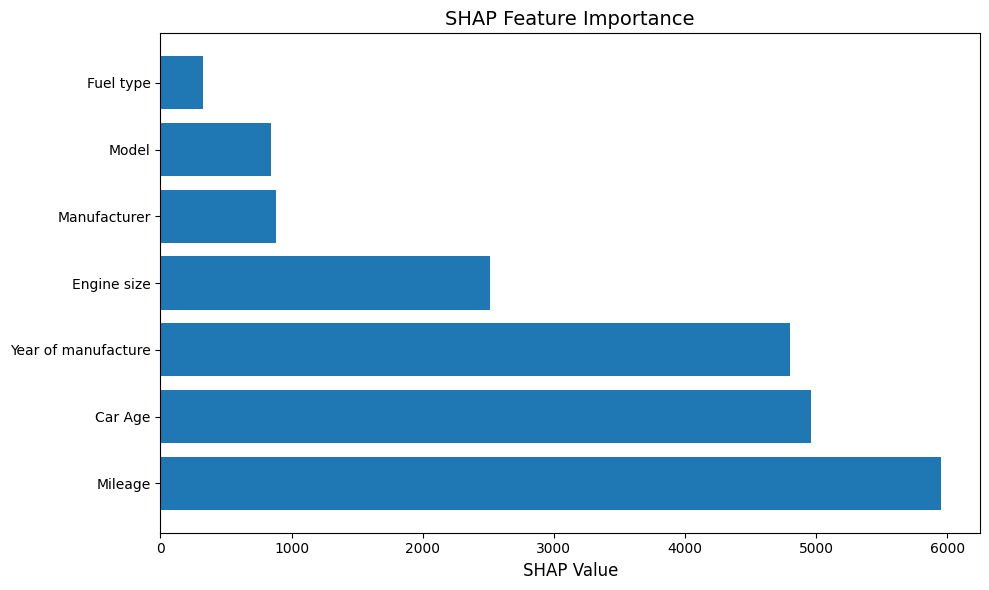

In [38]:
"Plot SHAP Feature Importance"
# Sort by importance (ascending for horizontal bar plot)
shap_df_sorted = shap_df.sort_values('SHAP_Importance', ascending=False)

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(shap_df_sorted['Feature'], shap_df_sorted['SHAP_Importance'], color='#1f77b4')

plt.xlabel('SHAP Value', fontsize=12)
plt.title('SHAP Feature Importance', fontsize=14)
plt.tight_layout()
plt.show()